# Лабораторная работа 4. Подбор гиперпараметров. Калибровка. Работа с текстовыми данными. Библиотека Vowpal Wabbit.

Результат лабораторной работы − отчет. Мы предпочитаем принимать отчеты в формате ноутбуков IPython (ipynb-файл). Постарайтесь сделать ваш отчет интересным рассказом, последовательно отвечающим на вопросы из заданий. Помимо ответов на вопросы, в отчете также должен быть код, однако чем меньше кода, тем лучше всем: нам − меньше проверять, вам — проще найти ошибку или дополнить эксперимент. При проверке оценивается четкость ответов на вопросы, аккуратность отчета и кода.

Мы уверены, что выполнение лабораторных работ занимает значительное время, поэтому не рекомендуем оставлять их на последний вечер перед сдачей.

### Оценивание и штрафы
* Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи)
* Максимально допустимая оценка за работу — 15 баллов
* Сдавать задание после указанного срока сдачи нельзя
* «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов и понижают карму (подробнее о плагиате см. на странице курса)
* Если вы нашли решение какого-то из заданий в открытом источнике, необходимо прислать ссылку на этот источник (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник)
* Не оцениваются задания с удалёнными формулировкам
* Не оценивается лабораторная работа целиком, если она была выложена в открытый источник

Обратите внимание, что мы не ставим оценку за просто написанный код, корректная работоспособность которого не подтверждена экспериментами.

### Правила сдачи
Выполненную работу следует отправить в систему Anytask. Более подробно о системе можно почитать на странице курса. Название отправляемого файла должно иметь следующий формат: Surname_Name_Group_NN.ipynb, где NN — номер лабораторной работы. Например, Kozlova_Anna_CS_04.ipynb.

## Оценивание качества классификации

Перед тем, как приступить к выполнению заданий, рассмотрим метрики классификации, которые нам пригодятся в дальнейшем.

### Accuracy, Precision, Recall

- Accuracy: $$ Accuracy = \frac{1}{l}\sum_{i=1}^l[y_i = \hat{y}_i]$$ где $y_i$ — истинный ответ на объекте $x_i$, $\hat{y}_i$ — предсказанный. (Мы не рекомендуем переводить *accuracy* как точность, потому что в русскоязычной литературе точностью называют другую метрику)
- Precision (точность): $$Precision = \frac{TP}{TP + FP}$$
- Recall (полнота): $$Recall = \frac{TP}{TP + FN}$$

где обозначения *TP*, *FP*, *FN* и *TN* — элементы матрицы ошибок:

| | y = 1 | y = 0 |
|------|------|
|   a(x) = 1  | TP| FP |
| a(x) = 0| FN | TN |

Обратите внимание, что точность и полнота вычисляются относительно фиксированного класса. В sklearn есть удобная функция [classification_report](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html), позволяющая сразу вычислять эти метрики для всех классов. 

Точность и полнота хороши тем, что могут быть использованы в случае несбалансированных данных, однако сразу же две метрики оптимизировать не удобно.

### Precision-Recall кривая

Зачастую классификатор может возвращать не конкретный класс, а некоторую меру принадлежности заданному классу $b(x)$. Затем значение $b(x)$ сравнивается с фиксированным порогом *t*, и на самом деле классификатор имеет вид $a(x) = [b(x) > t]$. Таким образом, при оценивании качества работы классификатора можно использовать его ответ $b(x)$ и подбирать порог *t* исходя из некоторых условий. Кроме того, выбор порога влияет на качество классификации:
 - чем больше $t$, тем выше точность, но ниже полнота,
 - чем меньше $t$, тем выше полнота, но ниже точность.

Раз мы умеем варьировать порог классификатора, тем самым меняя качество, интересно каким оно будет при всех возможных различных порогах. Для этого строят следующий график: переберем все возможные пороги $t$, откладывая по оси OX полноту получившегося классификатора, а по оси OY — точность. Таким образом можно получить хорошую визуализацию качества алгоритма.

### ROC кривая

Еще один из способ визуализации зависимости метрик качества от порога, подходящей в этом случае, является *ROC*. По осям: 
 - OX: $FPR = \frac{FP}{FP + TN}$
 - OY: $TPR = \frac{TP}{TP + FN}$

Как следствие, можно измерять площади под указанными кривыми — *Precision-Recall AUC* и *AUC-ROC* соответственно.

### LogLoss

В бинарном случае эта метрика записывается как $$logloss = -\dfrac{1}{N}\sum_{i=1}^N (y_i\log{p_i} + (1-y_i)\log{(1 - p_i)})$$

В отличии от *AUC-ROC*, для этой метрики необходимо, чтобы классификатор умел предсказывать вероятность принадлежности к классу, а не "степень принадлежности классу 1" в неопределенной шкале. Приведем пример. Вероятностная шкала может быть нужна, если вы хотите оценить количество денег, которые в среднем принесёт пользователь, кликнув на баннер. Для этого необходимо умножить количество денег, которые вы получаете за клик на баннер, на вероятность клика пользователя, которую предсказывает модель.

## Подбор гиперпараметров. Случайный поиск по сетке

Вы уже знаете, что для подбора гиперпараметров есть способ перебора по сетке. Обычно перебор некоторых значений гиперпараметров ведется по логарифмической шкале, так как это позволяет быстрее определить какого порядка должен быть параметр, и в то же время значительно уменьшить время поиска. Последний нюанс бывает особо критичен, так как для каждого фиксированного набора гиперпараметров происходит новое обучение алгоритма и оценка качества. 

Однако такой подход к нахождению гиперпараметров является не единственным возможным. Рассмотрим более подробно в чем может заключаться недостаток предыдущего подхода. Допустим, вам нужно подобрать 2 гиперпараметра, для каждого из которых есть сетка из 4 возможных значений. То есть всего 16 итераций обучения по сетке. Допустим также, что для оценки качества используется 5-fold CV. В итоге алгоритм будет обучен 80 раз, что уже немало. А если, например, рассмотреть случайный лес, где гиперпараметрами могут являться критерий ветвления, максимальная глубина деревьев, минимальное число объектов в листьях, максимальное число признаков, количество листьев и так далее, может получиться экспоненциально большое число обучений алгоритма, что займёт очень много времени. Для того чтобы как-то ускорить процесс и в то же время найти близкие к оптимальным значения используют **случайный** поиск по сетке. В этом случае для каждого гиперпараметра задается распределение, из которого выбираются его значения. И так как каждый раз значение каждого гиперпараметра выбирается случайно, это позволяет находить оптимум быстрее. 

Сравнение обычного поиска по сетке со случайным можно проиллюстрировать следующим образом:

![](http://blog.kaggle.com/wp-content/uploads/2015/07/scikitlearn8.jpeg)

Более детально о случайном поиске по сетке можно прочесть по следующим ссылкам:
 - теоретический анализ случайного поиска [Random Search for Hyper-Parameter Optimization](http://jmlr.csail.mit.edu/papers/volume13/bergstra12a/bergstra12a.pdf)
 - кратко и с юмором [Smarter Parameter Sweeps (or Why Grid Search Is Plain Stupid)](https://medium.com/rants-on-machine-learning/smarter-parameter-sweeps-or-why-grid-search-is-plain-stupid-c17d97a0e881#.pkwq17od8)
 
В sklearn случайный поиск по сетке реализован в классе [RandomizedSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV).

При выполнении этой части задания будем использовать [набор данных](http://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients) с информацией о клиентах банка и их платежах.

![](https://s2.postimg.org/jm4gryimx/dataset-cover.jpg)

Загрузите данные из файла *credit_card_clients.tsv* и разбейте на обучающее и тестовое множество в отношении 4 к 1.

In [184]:
import pandas as pd

data = pd.read_csv('credit_card_clients.tsv', sep='\t').drop(['ID'], axis=1)
data.index += 1

In [185]:
data.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [186]:
X, y = data.drop(['default payment next month'], axis=1), data['default payment next month']

In [80]:
X.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
1,20000,2,2,1,24,2,2,-1,-1,-2,...,689,0,0,0,0,689,0,0,0,0
2,120000,2,2,2,26,-1,2,0,0,0,...,2682,3272,3455,3261,0,1000,1000,1000,0,2000
3,90000,2,2,2,34,0,0,0,0,0,...,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
4,50000,2,2,1,37,0,0,0,0,0,...,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
5,50000,1,2,1,57,-1,0,-1,0,0,...,35835,20940,19146,19131,2000,36681,10000,9000,689,679


In [84]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)

**(2 балла) Задание 1.**

Целью данного задания является сравнение описанных выше подходов подбора гиперпараметров на практике. А именно, посмотрим как ведет себя обычный и случайный поиск по сетке при одинаковом числе операций (бюджете). Попробуем найти оптимальные гиперпараметры для SVM с линейным ядром. В данном случае нам будет интересно найти значения у двух гиперпараметров: коэффициент регуляризации *C* и количество итераций *max_iter*. Для обоих гиперпараметров возьмите логарифмическую шкалу (см. функцию [logspace](http://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.logspace.html)), для *C* от 0.1 до 100, для *max_iter* от 1000 до 10000. В качестве оптимизируемой метрики качества выберем *AUC-ROC*.

 - Для обычного поиска по сетке ([GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV)) подготовьте 5 сеток гиперпараметров, так чтобы каждый у каждого гиперпараметра перебиралось 2, 3, 4, 5 и 6 значений в соответствующей сетке. Таким образом у вас получится 5 запусков поиска параметров с бюджетом 4, 9, 16, 25, 36. 

 - Для случайного поиска ([RandomizedSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV)) сделайте 5 запусков поиска гиперпараметров с бюджетом 4, 9, 16, 25, 36. 

 - Для каждого из запусков алгоритма подбора гиперпараметров (одного — обычной и 5 для случайного) вычислите наилучшее достигнутое качество для каждого бюджета. После чего постройте график, где по оси OX будет отложен бюджет, а по оси OY — наилучшее качество.
 
Данная часть лабораторной работы может работать значительное время. Поэтому рекомендуем обратить внимание на параметр *n_jobs* поиска по сетке (есть у обоих классов).

In [86]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

grid = [{'C' : np.logspace(-1, 2, 2),     'max_iter' : np.logspace(3, 4, 2)},
        {'C' : np.logspace(-1, 2, 3),     'max_iter' : np.logspace(3, 4, 3)},
        {'C' : np.logspace(-1, 2, 4),     'max_iter' : np.logspace(3, 4, 4)},
        {'C' : np.logspace(-1, 2, 5),     'max_iter' : np.logspace(3, 4, 5)},
        {'C' : np.logspace(-1, 2, 6),     'max_iter' : np.logspace(3, 4, 6)}]

svm = SVC(kernel = 'linear', random_state = 42, probability = True)
best_par = []
best_scores = []
for i in range(5):
    parameters = grid[i]
    clf = GridSearchCV(svm, parameters, cv = 5, scoring = 'roc_auc', n_jobs = -1)
    clf.fit(X_train, y_train)
    best_par.append(clf.best_params_)
    best_scores.append(clf.best_score_)
    print("Grid number: ", i)
    print("Best parameters:", clf.best_params_)
    print("Best cross validaton score:", clf.best_score_)
    print("\n")

Grid number:  0
Best parameters: {'C': 100.0, 'max_iter': 10000.0}
Best cross validaton score: 0.569896805516


Grid number:  1
Best parameters: {'C': 0.10000000000000001, 'max_iter': 3162.2776601683795}
Best cross validaton score: 0.579050586448


Grid number:  2
Best parameters: {'C': 0.10000000000000001, 'max_iter': 4641.5888336127773}
Best cross validaton score: 0.583161470403


Grid number:  3
Best parameters: {'C': 3.1622776601683795, 'max_iter': 5623.4132519034911}
Best cross validaton score: 0.624176350181


Grid number:  4
Best parameters: {'C': 100.0, 'max_iter': 2511.8864315095798}
Best cross validaton score: 0.571966093813




In [107]:
from sklearn.model_selection import RandomizedSearchCV

grid = [{'C' : np.logspace(-1, 2, 2),     'max_iter' : np.logspace(3, 4, 2)},
        {'C' : np.logspace(-1, 2, 3),     'max_iter' : np.logspace(3, 4, 3)},
        {'C' : np.logspace(-1, 2, 4),     'max_iter' : np.logspace(3, 4, 4)},
        {'C' : np.logspace(-1, 2, 5),     'max_iter' : np.logspace(3, 4, 5)},
        {'C' : np.logspace(-1, 2, 6),     'max_iter' : np.logspace(3, 4, 6)}]

svm = SVC(kernel = 'linear', random_state = 42, probability = True)
best_par_rand = []
best_scores_rand = []
budget = [4, 9, 16, 25, 36] 
for i in range(5):
    r_clf = RandomizedSearchCV(svm, 
                               param_distributions = grid[i], 
                               scoring = 'roc_auc', 
                               n_iter = budget[i], 
                               n_jobs = -1)
    r_clf.fit(X_train, y_train)
    best_par_rand.append(r_clf.best_params_)
    best_scores_rand.append(r_clf.best_score_)
    print("Budget: ", i)
    print("Best parameters:", r_clf.best_params_)
    print("Best cross validaton score:", r_clf.best_score_)
    print("\n")

Budget:  0
Best parameters: {'max_iter': 10000.0, 'C': 100.0}
Best cross validaton score: 0.562226488234


Budget:  1
Best parameters: {'max_iter': 3162.2776601683795, 'C': 100.0}
Best cross validaton score: 0.579323301214


Budget:  2
Best parameters: {'max_iter': 4641.5888336127773, 'C': 1.0}
Best cross validaton score: 0.59136865345


Budget:  3
Best parameters: {'max_iter': 10000.0, 'C': 0.56234132519034907}
Best cross validaton score: 0.591461727879


Budget:  4
Best parameters: {'max_iter': 10000.0, 'C': 1.5848931924611134}
Best cross validaton score: 0.617766571625




Нарисуем теперь графики для обычного поиска по сетке и для случайного.

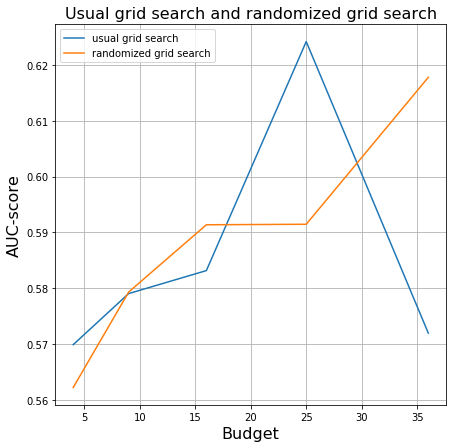

In [109]:
plt.figure(figsize = (7, 7))

plt.plot(np.array(budget), np.array(best_scores), label='usual grid search')
plt.plot(np.array(budget), np.array(best_scores_rand), label='randomized grid search')


plt.xlabel('Budget', fontsize = 16)
plt.ylabel('AUC-score', fontsize = 16)
plt.title('Usual grid search and randomized grid search', fontsize = 16)
plt.legend(loc = 'best')
plt.grid()
plt.show()

На графиках видно, что для обычного GridSearch при увеличении бюджета качество улучшается до некоторого момента, но потом начинает падать. Поэтому слишком большой бюджет для GridSearch  не имеет смысла -- стоит найти его оптимальное значение и использовать его. В нашем случае это значение равно 25.

**(1 балл) Задание 2.**

Сравните полученные графики для разных способов подбора гиперпараметров:
 * Посмотрите на наилучшие гиперпараметры, которые у вас получились. Можно ли сказать, что какой-то из гиперпараметров больше влияет на результат?

Для GridSearch из всех пяти экспериментов дважды получалось C=0.1 и C=100, и при очень разеых значениях max_iter качество изменялось слабо. Хотя, в то же время, при C=0.1 и C=100 есть два примера, на которых качество почти одинаковое. В общем, сложно сказать.

Для RandomizedGridSearch в 3 из 5 случаев получилось max_iter=10000, а качество колебалось уже в зависимости от значений C, поээтому здесь большее влияние оказывал параметр C.

* Можно ли сделать вывод, что случайный поиск проигрывает или же наоборот?

При малом бюджете выигрывает GridSearch, но потом доходит до своего максимума при росте бюджета и начинает убывать. А вот RandomizedGridSearch хорошо себя показал на больших бюджетах и обучался быстрее. Поэтому можно скорее сказать, что случайный поиск выигрывает.

* Зависит ли ответ на предыдущий вопрос от размера бюджета и удачной инициализации?

От размера бюджета зависит, как уже было сказано выше. Для RandomGridSearch многое зависит от удачной инициализации, поэтому график вышел скачущим. Видно, что лучшее значение качества у случайного поиска хуже, чем у обычного. Возможно, при другой инициализации это было бы не  так.

## Калибровка классификатора

Рассмотрим в задачу, где целевой метрикой является *logloss*. Как было сказано выше, в этом случае необходимо, чтобы классификатор умел предсказывать вероятность принадлежности к классу. К сожалению, на практике часто получается так, что либо классификатор не обладает желаемым свойством (например, SVM без специальных настроек), либо метод *predict_proba* возвращает некорректную вероятность (например, случайный лес возвращает среднее арифметическое вероятностей от каждого дерева, которое не обязано являться корректной вероятностью, подробнее [здесь](http://people.dsv.su.se/~henke/papers/bostrom08b.pdf)).

В этом случае возможны несколько подходов: 
 - Заменить классификатор на тот, который умеет предсказывать вероятности.
 - Воспользоваться калибровкой ответов.
 
В общем случае первый подход не самый удачный выбор, так как накладывает ограничения на модели, которые можно использовать. Поэтому рассмотрим второй более подробно. По умолчанию SVM может вычислять отступ от заданного объекта до разделяющей гиперплоскости, а не возвращать вероятности. После чего можно обучить преобразование, которое искажает возвращаемое значение в вероятность  — это и называется **калибровкой**. Есть несколько известных методов калибровки:
 - Калибровка Платта.
 - Изотоническая регрессия.

Обратите внимание, что преобразование необходимо обучать на отложенной выборке (то есть классификатор и калибровка должны обучаться на разных подмножествах данных), иначе можно переобучиться. Калибровку можно применять к любым классификаторам (где это разумно и необходимо), особенно к тем, которые не оптимизируют logloss явно.

Для калибровки классификатора в sklearn возможны два подхода:
 - взять уже обученный классификатор и откалибровать его на отложенной выборке
 - откалибровать по кросс-валидации: калибровочному классификатору передается вся обучающая выборка, которая внутри разбивается на обучающую и калибровочную, после чего происходит усреднение вероятностей по фолдам.
 
Подробнее об этом можно прочитать в [документации](http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html#sklearn.calibration.CalibratedClassifierCV). Также [здесь](https://jmetzen.github.io/2015-04-14/calibration.html) можно узнать подробности о калибровке в sklearn от автора.

Замечание: выше написано, что SVM по умолчанию не возвращает вероятности. Если же заглянуть в документацию [SVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html), то можно найти параметр *probability*. Если установить его равным *True*, то у такого классификатора можно вызвать метод *predict_proba* и получить оценки вероятностей. В библиотеке реализована калибровка Платта и с классификатором проделывается примерно тоже самое, что было описано выше. Использование этого параметра замедляет процесс обучения, зато позволяет сразу же использовать данный классификатор для оценивания вероятностей. Обратите внимание, что у класса [LinearSVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html) такой опции нет.

**(2 балла) Задание 3.**
 
Рассмотрим SVM из предыдущего пункта. Используйте оба описанных выше подхода (калибровку Платта и изотоническую регрессию) для калибровки классификатора. Для каждого из подходов постройте график, на котором будут изображены [калибровочные кривые](http://scikit-learn.org/stable/modules/generated/sklearn.calibration.calibration_curve.html): идеальная, исходного классификатора, а также для каждого из методов на обучающей выборке. Калибровочная кривая строится путем упорядочения всех объектов по предсказанному значению, которые разбиваются на бины. По оси OX откладывается среднее предсказанное значение вероятности по бину, а по OY — доля положительных примеров. В случае идеальных вероятностей это будет прямая.
 
В данном задании необходимо воспользоваться методом *decision_function*, возвращающим значение отступа на объекте. После этого отмасштабируйте полученные отступы в интервал [0, 1], применив сигмоиду или линейное преобразование.

Функция для отрисовки кривых взята отсюда: 

https://jmetzen.github.io/2015-04-14/calibration.html

In [232]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [233]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [234]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve
from sklearn.svm import LinearSVC, SVC

def DrawCalibrationCurve():
    isotonic = CalibratedClassifierCV(LinearSVC(), cv=5, method='isotonic')
    sigmoid = CalibratedClassifierCV(LinearSVC(), cv=5, method='sigmoid')

    plt.figure(2, figsize=(9, 9))
    
    plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    probas = []
    for clf, name in [(LinearSVC(), 'SVC'),
                      (isotonic, 'SVC Isotonic'),
                      (sigmoid, 'SVC Sigmoid')]:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        if hasattr(clf, 'predict_proba'):
            prob_pos = clf.predict_proba(X_test)[:, 1]
        else:  # use decision function
            prob_pos = clf.decision_function(X_test)
            prob_pos = (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
        probas.append(prob_pos)
        fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_test, prob_pos, n_bins=10)

        plt.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label=name)

    plt.ylabel("Fraction of positives")
    plt.xlabel("Mean predicted value")
    plt.legend(loc="best")
    plt.title('Calibration plots', fontsize=20)

    plt.tight_layout()
    return probas

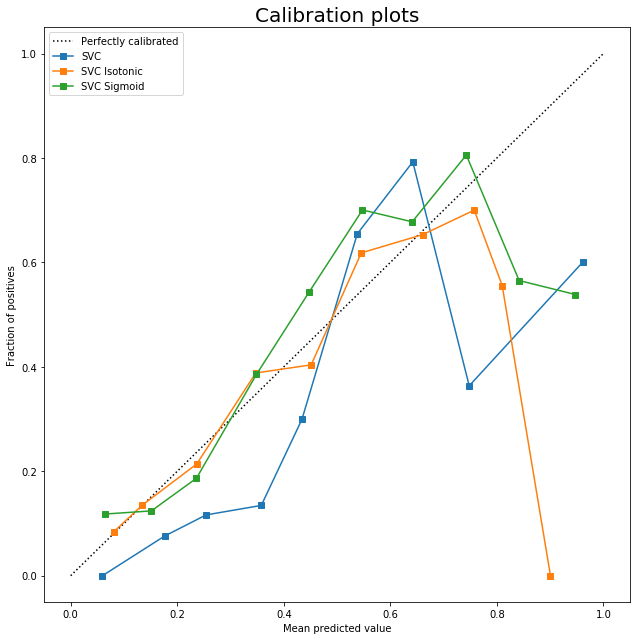

In [235]:
probas = DrawCalibrationCurve()

**(1 балл) Задание 4.**
 - Посчитайте *logloss* на тестовой выборке для исходного и классификатора после калибровки.

In [237]:
print('SVC: {}'.format(metrics.log_loss(y_test, probas[0])))
print('SVC isotonic: {}'.format(metrics.log_loss(y_test, probas[1])))
print('SVC sigmoid: {}'.format(metrics.log_loss(y_test, probas[2])))

SVC: 0.5498612370841962
SVC isotonic: 0.45291154437164355
SVC sigmoid: 0.46452830535550854


- Дает ли калибровка прирост качества относительно метрики logloss?

Даёт, так как значение log_loss уменьшилось.

- Какой из способов калибровки в данном случае работает лучше?

Если судить по значению logloss, то isotonic.

- Какой из подходов (калибровка на отложенной выборке или по кросс-валидации) дает более хороший результат?

До этого был получен результат с помощью кросс-валидации. Попробуем теперь подход с отложенной выборкой.

In [238]:
X_tr, X_calib, y_tr, y_calib = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [240]:
svc = LinearSVC()
svc.fit(X_tr, y_tr)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

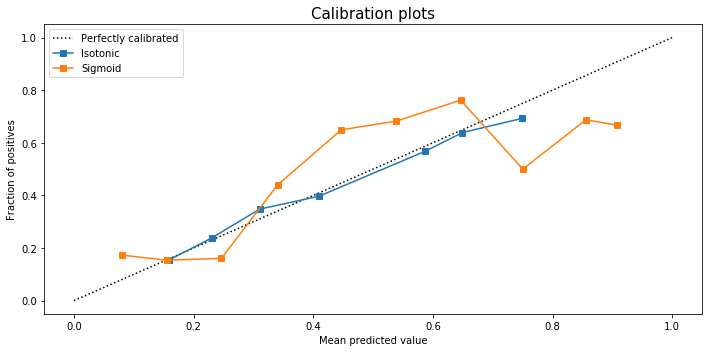

In [243]:
isotonic = CalibratedClassifierCV(est, cv='prefit', method='isotonic')
sigmoid = CalibratedClassifierCV(est, cv='prefit', method='sigmoid')

isotonic.fit(X_calib, y_calib)
sigmoid.fit(X_calib, y_calib)

proba_isot = isotonic.predict_proba(X_test)[:, 1]
fraction_of_positives_isot, mean_predicted_value_isot = calibration_curve(y_test, 
                                                                     prob_isot, 
                                                                     n_bins=10)

proba_sigm = sigmoid.predict_proba(X_test)[:, 1]
fraction_of_positives_sigm, mean_predicted_value_sigm = calibration_curve(y_test, 
                                                                     prob_sigm, 
                                                                     n_bins=10)

fig = plt.figure(3, figsize=(10, 5))
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.plot(mean_predicted_value_isot, fraction_of_positives_isot, "s-",
             label='Isotonic')
plt.plot(mean_predicted_value_sigm, fraction_of_positives_sigm, "s-",
             label='Sigmoid')



plt.ylabel("Fraction of positives")
plt.xlabel("Mean predicted value")
plt.legend(loc="best")
plt.title('Calibration plots', fontsize=15)

plt.tight_layout()

In [244]:
print('SVC isotonic: {}'.format(metrics.log_loss(y_test, proba_isot)))
print('SVC sigmoid: {}'.format(metrics.log_loss(y_test, proba_sigm)))

SVC isotonic: 0.4738200115083161
SVC sigmoid: 0.4948267228957644


Если судить по графикам (и их приближённости к идеальной калибровке), то подход с отложенной выборкой даёт хороший результат. Однако значения LogLoss несколько хуже, чем при кросс-валидации.

- Почему калибровка практически не должна повлиять на *AUC-ROC*? 

Потому что калибровка одинаково влияет на TPR и FPR, то есть узлы ROC-кривой останутся на месте и она не изменится, и следовательно, площадь под ней -- тоже.

## Работа с текстовыми данными

В остальной части задания мы будем работать с подмножеством датасета IMDB Movies Reviews из соревнования [Bag of Words Meets Bags of Popcorn](https://www.kaggle.com/c/word2vec-nlp-tutorial/data). 
![](http://i.imgur.com/QZgxFic.png)

Задача состоит в следующем: по отзыву на фильм необходимо понять является ли он положительным или отрицательным. Это один из примеров задачи анализа тональности текста ([sentiment analysis](https://en.wikipedia.org/wiki/Sentiment_analysis)). Пример отзыва из выборки:
    
    This can be one of the most enjoyable movies ever if you don't take it seriously. It is a bit dated and the effects are lame, but it is so enjoyable. There are giant crabs that attack a girl. oh, and the crabs sing Japanese. It is amazingly bad. And the ending, which has been telegraphed throughout the entire film is hideously awesome. Predictable, but seeing the final fight will leave you rolling in your seat. Don't even give this film a chance and you will love it. Susan George is fun to watch and yes, she does appear naked. Her daughter isn't quite worth putting up with, but she does get attacked by giant crabs. They are the size of large cats. This is a 2, but I love it. As a movie, my God, but for entertainment, I give it a 7. Did I mention there are giant crabs?

Загрузите датасет из файла *feedback_data.tsv*.

In [8]:
import warnings
warnings.filterwarnings('ignore')

In [248]:
import pandas as pd
import pylab as pl
import seaborn
import numpy as np
import re
%pylab inline
import os

os.chdir("/Users/apple/Desktop/ШАД/ML/4")
df = pd.read_csv('feedback_data.tsv', sep='\t')
df[:10]

Populating the interactive namespace from numpy and matplotlib


,id,sentiment,review
0,6678_2,0,"This is a copy of the 1948 Doris Day classic, ..."
1,11589_3,0,Bottom-of-the-Freddy barrel. This is the worst...
2,6760_2,0,Renown writer Mark Redfield (as Edgar Allen Po...
3,1150_4,0,Although there are some snippets in this 4-par...
4,11913_4,0,"A good idea, badly implemented. While that cou..."
5,6628_1,0,If the scale went negative I would be happier....
6,7218_1,0,There is a scene near the beginning after a sh...
7,6922_3,0,The one sheets and newspaper campaign suggeste...
8,215_4,0,I am not so much like Love Sick as I image. Fi...
9,8155_1,0,I actually prefer Robin Williams in his more s...


Для оценивания качества в данной задаче мы будем использовать отложенную выборку. Разделите все данные на две части: 16000 объектов будут в обучающей выборке и 4000 объектов — в тестовой.

При разбиении выборки на две части, необходимо будет учесть следующие особенности разбиения:
 - разбиение должно быть воспроизводимо;
 - соотношение классов в каждой из частей должно сохраняться (например, при использовании функции *train_test_split* указать *stratify*).

In [249]:
y = df['sentiment']
X = df.drop('sentiment', axis=1)

In [250]:
X['review'][0]

"This is a copy of the 1948 Doris Day classic, Romance on the High Seas.<br /><br />The story line is more or less same but is contemporary. Govinda plays a sharp witted fellow who replaces the husband on the trip. While Rani plays the college friend of the wife who does her the same favour. They ostensibly try to catch each other out while the actual husband and wife tries to trip each other in Bombay.<br /><br />On the trip, Govinda mistakes another girl for Sanjiv's wife and spies on her while falling in love with the ravishing Rani.<br /><br />Lever plays a dual role of father and son both lawyers specialising in divorce proceedings. They are pitted against each other for the warring couple.<br /><br />It is a poor attempt at copying the original classics and the songs are quite appalling. The comedy is slap-stick and will not make one laugh too much."

In [251]:
from sklearn import cross_validation, datasets

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, 
                                                                     test_size = 0.2, 
                                                                     random_state = 42, 
                                                                     stratify = y)
X_train.shape

(16000, 2)

In [252]:
X_train.reset_index(inplace = True)
X_test.reset_index(inplace = True)

Одна из сложностей данной задачи — текстовое представление данных, так как не существует какого-то универсального способа извлечения признаков из текстов. По ходу работы мы получим несколько наборов признаков, которые будем сравнивать между собой.

Для начала попробуем самый простой подход, а именно [bag-of-words](https://en.wikipedia.org/wiki/Bag-of-words_model) кодирование данных. С помощью него каждый текст будет представлен в виде вектора, размер которого равен размеру словаря, а на каждой позиции стоит число, сколько раз соответствующее слово встретилось в этом тексте. Для данного подхода хорошей практикой является фильтрация стоп-слов.

Такое представление можно получить используя класс [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer) из библиотеки sklearn. Одно из удобств данного метода состоит в том, что возвращаемый результат является [sparse](http://docs.scipy.org/doc/scipy-0.15.1/reference/sparse.html)-матрицей, так как при таком преобразовании получается достаточно много нулей. Более подробно про такие матрицы было рассказано на [семинаре](https://nbviewer.jupyter.org/urls/dl.dropbox.com/s/xswzs2g414wggh9/seminar_8.ipynb), также про это можно прочитать, например, [здесь](http://www.scipy-lectures.org/advanced/scipy_sparse/index.html).

Примените *bag-of-words* кодирование данных. Мы рекомендуем здесь и в дальнейшем обучать преобразование на обучающей выборке, после чего применять его к тестовой. Какой размерности стали данные?

Преобразуем сначала данные обучающей выборки.

In [18]:
import nltk
nltk.download() 

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [20]:
from nltk.corpus import stopwords
print(stopwords.words("english")[:10])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your']


Подготовим отзывы для работы классификаторов с помощью функции clean_reviews. Код взят с сайта Kaggle (ссылку я потеряла, но взято было из соревнования Bag of Words Meets Bags of Popcorn). 

In [21]:
from bs4 import BeautifulSoup 

def clean_reviews(review):
    # удаляем HTML
    review_text = BeautifulSoup(review).get_text() 
    #
    # удаляем всё, что не является буквами
    letters_only = re.sub("[^a-zA-Z]", " ", review_text) 
    #
    # разбиваем на отдельные слова
    words = letters_only.lower().split()                             
    #
    # переводим стопслова в тип set, так как на питоне быстрее осуществляется поиск по множеству, чем по списку
    stops = set(stopwords.words("english"))                  
    # 
    # удаляем стоп-слова
    meaningful_words = [w for w in words if not w in stops]   
    #
    # соединяем слова в одну строку, разделяем их пробелами
    return( " ".join( meaningful_words ))   


In [31]:
number_of_reviews = X_train["review"].size

clean_train_reviews = []

for i in range(0, number_of_reviews):
    if ((i + 1) % 1000 == 0):
         print("Review %d of %d" % (i + 1, number_of_reviews)) 
    clean_train_reviews.append(clean_reviews( X_train["review"][i]))

Review 1000 of 16000
Review 2000 of 16000
Review 3000 of 16000
Review 4000 of 16000
Review 5000 of 16000
Review 6000 of 16000
Review 7000 of 16000
Review 8000 of 16000
Review 9000 of 16000
Review 10000 of 16000
Review 11000 of 16000
Review 12000 of 16000
Review 13000 of 16000
Review 14000 of 16000
Review 15000 of 16000
Review 16000 of 16000


In [32]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(analyzer = "word", 
                             tokenizer = None, 
                             preprocessor = None, 
                             stop_words = None) 
train_data_features = vectorizer.fit_transform(clean_train_reviews)
train_data_features = train_data_features.toarray()

Проверим, какой размерности стали обучающие данные.

In [33]:
print(train_data_features.shape)

(16000, 61655)


In [34]:
print(len(vectorizer.vocabulary_))

61655


Преобразуем теперь тестовые данные. Обучение для vectorizer теперь не делаем, а только трансформируем текстовые данные в числа.

In [35]:
number_of_reviews = X_test["review"].size

clean_test_reviews = []

for i in range(0, number_of_reviews):
    if ((i + 1) % 1000 == 0):
         print("Review %d of %d" % (i + 1, number_of_reviews))  
    clean_test_reviews.append(clean_reviews(X_test["review"][i]))

Review 1000 of 4000
Review 2000 of 4000
Review 3000 of 4000
Review 4000 of 4000


In [162]:
test_data_features = vectorizer.transform(clean_test_reviews)
test_data_features = test_data_features.toarray()

**(0.5 балла) Задание 5.**

Какие недостатки для данной задачи вы видите у метрики *Accuracy*?

In [42]:
df.sentiment.value_counts()

0    12500
1     7500
Name: sentiment, dtype: int64

Видно, что классы несбалансированы: отрицательных отзывов намного больше. Метрика accuracy может давать хороший результат, если классификатор будет выдавать только одни нули независимо от отзыва.

Обучите логистическую регрессию и случайный лес с 500 деревьев на *bag-of-words* представлении выборки и измерьте качество на тестовых данных с помощью трех описанных выше метрик: *Accuracy*, *Precision*, *Recall*. Кроме того, сравните **время** обучения алгоритмов.

In [43]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators = 500, n_jobs=-1, random_state = 42) 
%time forest = forest.fit(train_data_features, y_train)

CPU times: user 1h 23min 37s, sys: 1min 47s, total: 1h 25min 24s
Wall time: 13min 10s


In [163]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(n_jobs = -1, random_state = 42)
%time lr = lr.fit(train_data_features, y_train)

CPU times: user 17.8 s, sys: 26.4 s, total: 44.2 s
Wall time: 46.3 s


Измерим теперь качество для обоих алгоритмов. Начнём с логистической регрессии.

In [161]:
from sklearn import metrics

In [47]:
print("Accuracy for logistic regression")

predictions_lr = lr.predict(test_data_features)
metrics.accuracy_score(y_test, predictions_lr)

Accuracy for logistic regression


0.87175000000000002

In [48]:
from sklearn.metrics import classification_report

target_names = ['class 0', 'class 1']
print(classification_report(y_test, predictions_lr, target_names = target_names))

             precision    recall  f1-score   support

    class 0       0.90      0.89      0.90      2500
    class 1       0.83      0.83      0.83      1500

avg / total       0.87      0.87      0.87      4000



Теперь измерим качество для RandomForest.

In [50]:
print("Accuracy for random forest")

predictions_forest = forest.predict(test_data_features)
metrics.accuracy_score(y_test, predictions_forest)

Accuracy for random forest


0.83350000000000002

In [51]:
print(classification_report(y_test, predictions_forest, target_names = target_names))

             precision    recall  f1-score   support

    class 0       0.81      0.97      0.88      2500
    class 1       0.92      0.61      0.73      1500

avg / total       0.85      0.83      0.82      4000



Есть ли существенная разница в качестве предсказаний данных алгоритмов? Какой из методов кажется менее применимым в данной задаче и почему?

Особенной разницы в качестве классфикации нет, но можно заметить, что Random Forest справился хуже -- accuracy для него меньше, полнота для первого класса 0.61, а для логистической регрессии -- 0.87. Возможно, такая маленькая полнота для Random Forest на первом классе связана с дисбалансом классов. При большой размерности данных он дольше обучается. Поэтому менее применимым кажется Random Forest.

Посмотрев на указанные метрики, можно понять, что классификаторы неплохо справляются с нулевым классом и похуже — с первым. Скорее всего, это является следствием того, что положительных отзывов почти вдвое меньше чем отрицательных. В дальнейшем нас будет интересовать как классификатор справляется именно с положительными отзывами (то есть с первым классом).

**(1.5 балла) Задание 6.**

Постройте *Precision-Recall* и *ROC* кривые обученных выше классификаторов (каждый тип кривой на отдельном графике), а также вычислите площадь под ними. Для этого удобно воспользоваться функциями [precision_recall_curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html), [roc_curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html) и [auc](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html#sklearn.metrics.auc). Не забудьте, что в данном случае необходимо использовать метод *predict_proba* для получения оценки принадлежности к первому классу.

Начнём с логистической регрессии.

In [164]:
predpr_lr = lr.predict_proba(test_data_features)

In [53]:
predpr_lr[:10]

array([[  9.99653515e-01,   3.46484508e-04],
       [  4.15152530e-05,   9.99958485e-01],
       [  4.76969619e-09,   9.99999995e-01],
       [  9.99995750e-01,   4.24963979e-06],
       [  9.95559696e-01,   4.44030377e-03],
       [  4.72357968e-07,   9.99999528e-01],
       [  9.71630383e-01,   2.83696174e-02],
       [  9.75669091e-01,   2.43309094e-02],
       [  3.56283185e-01,   6.43716815e-01],
       [  3.82222428e-02,   9.61777757e-01]])

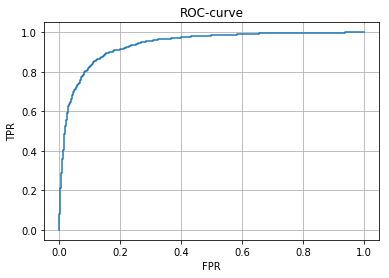

In [165]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, predpr_lr[:, 1])
plt.plot(fpr, tpr)
plt.title('ROC-curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid()
plt.show()

Площадь под ней:

In [166]:
print('AUC-ROC:', metrics.auc(fpr, tpr))

AUC-ROC: 0.937874933333


Построим *precision-recall*-кривую и найдём площадь под ней.

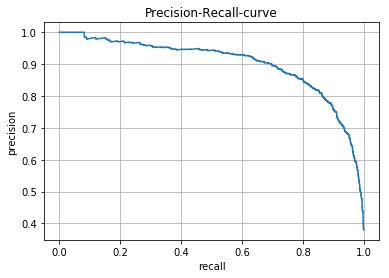

In [58]:
precision, recall, thresholds = metrics.precision_recall_curve(y_test, predpr_lr[:, 1])
plt.plot(recall, precision)
plt.title('Precision-Recall-curve')
plt.xlabel('recall')
plt.ylabel('precision')
plt.grid()
plt.show()

In [59]:
print("AUC-PR: ", metrics.auc(recall, precision))

AUC-PR:  0.901321367681


Сделаем теперь всё то же самое для **случайного леса**.

In [60]:
predpr_forest = forest.predict_proba(test_data_features)

Кривая roc-auc и площадь под ней.

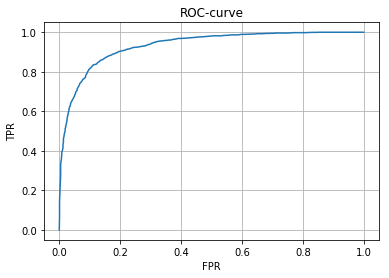

In [61]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, predpr_forest[:, 1])
plt.plot(fpr, tpr)
plt.title('ROC-curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid()
plt.show()

In [62]:
print('AUC-ROC:', metrics.auc(fpr, tpr))

AUC-ROC: 0.932960933333


Теперь *precision-recall*-кривая и площадь под ней.

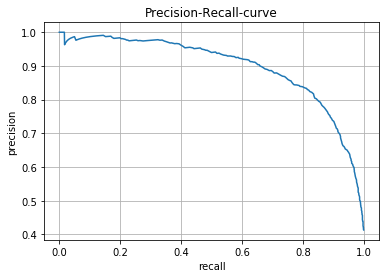

In [65]:
precision, recall, thresholds = metrics.precision_recall_curve(y_test, predpr_forest[:, 1])
plt.plot(recall, precision)
plt.title('Precision-Recall-curve')
plt.xlabel('recall')
plt.ylabel('precision')
plt.grid()
plt.show()

In [66]:
print("AUC-PR: ", metrics.auc(recall, precision))

AUC-PR:  0.898216702968


Если мы хотим, чтобы классификатор находил, например, не менее 80% положительных отзывов, то необходимо потребовать, чтобы полнота была не менее 0.8. 

**(1 балл) Задание 7.**

Найдите наибольшую точность, которую будет иметь каждый классификатор при полноте не менее 0.8.

Точность и полнота зависят от порога классификации. Поэтому будем перебирать различные пороги классификации h с шагом 0.03 и искать максимум точности при полноте не менее 0.8.

Начнём с логистической регрессии.

In [73]:
h = [0.03 * i for i in range (1, 34)]

Max_prec = 0
h0 = 0

for i in range (len(h)):
    for i in range (len(h)):
        pred_binary = (predpr_lr[:, 1] > h[i]).astype(np.int)
    
        pr = metrics.precision_score(y_test, pred_binary)
        rec = metrics.recall_score(y_test, pred_binary)
    
        if rec >= 0.8 and pr > Max_prec:
            h0 = h[i]
            Max_prec = pr
            rec_80 = rec

print("Maximum precision equals {2} with recall {0} and h = {1}".format(rec_80, 
                                                                      h[i], 
                                                                      Max_prec))

Maximum precision equals 0.8483779971791255 with recall 0.802 and h = 0.99


Точность вышла достаточно высокой, но и порог взят очень большим, что вряд ли хорошо на практике.

Теперь проделаем то же самое для случайного леса. 

In [76]:
h = [0.03 * i for i in range (1, 34)]

Max_prec = 0

for i in range (len(h)):
    for i in range (len(h)):
        pred_binary = (predpr_forest[:, 1] > h[i]).astype(np.int)
    
        pr = metrics.precision_score(y_test, pred_binary)
        rec = metrics.recall_score(y_test, pred_binary)
    
        if rec >= 0.8 and pr > Max_prec:
            Max_prec = pr
            rec_80 = rec

print("Maximum precision equals {2} with recall {0} and h = {1}".format(rec_80, 
                                                                      h[i], 
                                                                      Max_prec))

Maximum precision equals 0.8301630434782609 with recall 0.8146666666666667 and h = 0.99


Итак, ответ для логистической регрессии -- 0.84, для случайного леса -- 0.83.

В дальнейшем для экспериментов будем использовать логистическую регрессию. Можно заметить, что по некоторым причинам мы не находили оптимальные параметры для алгоритмов, а работали с параметрами по умолчанию. Чтобы исправить этот недостаток, в оставшейся части работы используйте понравившийся вам метод поиска гиперпараметров (из описанных выше) для нахождения наилучшего значения параметра *C* у логистической регрессии.

А теперь вернемся к исходной задаче. На данном этапе решения можно прийти к выводу, что предложенное кодирование текста может быть не самым удачным из-за большой матрицы объект-признак. Это ведет к ситуации, что не всякий алгоритм может быть применен в данной задаче по причине слишком большого признакового пространства, а кроме того, даже быстрые алгоритмы при наличии кросс-валидации могут начать работать медленно. Также в данных может быть шум, так как в качестве словаря были взяты все слова, даже те, которые встречались в одном-двух отзывах (например, опечатки). Поэтому кажется что неплохо было бы сократить размерность данных и по возможности избавиться от шума. 

## Отбор признаков и уменьшение размерности

### По частоте
Попробуем сформировать выборку, в которой будут находиться только самые "важные" признаки, то есть в данном случае слова. Например, это можно сделать оставив топ слов по частоте (не считая стоп-слов вроде "a", "the", "it", ...). Кажется, что вхождение наиболее частых слов в отзыве, например, *good*, *bad* и т.д. являются вполне неплохими показателями.

### С помощью машинного обучения
Другой подход — воспользоваться имеющимися методами машинного обучения, а именно обученным на всех признаках случайным лесом. С помощью сдучайного леса есть возможность оценивать важность признаков. То есть можно выбрать топ слов, важных как признаки для задачи классификации. 

### Hashing trick
Какие еще могут быть способы работы с такого рода данными? По факту слова в текстах — это некоторое очень разреженное представление (как мы убедились выше). Подходом, отличным от двух вышеперечисленных, является [хэширование](https://en.wikipedia.org/wiki/Feature_hashing) или hashing trick: каждому слову сопоставляется некоторый хэш, после чего делается, например, bag-of-words. Плюсом этого способа является возможность обрабатывать не встречавшиеся ранее слова. Этот подход реализован в классе [HashingVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.HashingVectorizer.html). Кроме того, если выставить параметр *non_negative=True*, то можно интерпретировать полученные значения как некоторые "частоты".

Заметьте, что два последних подхода можно применять не обязательно к текстовым данным.

**(2 балла) Задание 8.**

Сформируйте три новые выборки, где каждый объект будет иметь 15000 признаков, следующим образом:
 - топ самых частотных слов
 - топ наиболее "важных" слов с помощью случайного леса
 - с помощью хэширования
 
Для последних двух выборок не забывайте фильтровать стоп-слова, для этого можно использовать параметр stop_words='english' у классов CountVectorizer, HashingVectorizer.

На четырех выборках (*bag-of-words* и трех новых) постройте *roc*-кривые, вычислив площадь под ними.

Сформируем три новые выборки. Напомним, что столбец reviews был обработан раньше и стоп-слова были уже удалены, поэтому теперь мы их не удаляем.

### *15000 самых частотных слов*

In [120]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer_15th = CountVectorizer(max_features = 15000, analyzer = "word", tokenizer = None, preprocessor = None, 
                             stop_words = None) 

train_data_features = vectorizer_15th.fit_transform(clean_train_reviews)
train_data_features = train_data_features.toarray()

In [124]:
train_data_features.shape

(16000, 15000)

In [127]:
test_data_features = vectorizer_15th.transform(clean_test_reviews)
test_data_features = test_data_features.toarray()

In [132]:
test_data_features.shape

(4000, 15000)

In [128]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

lr = LogisticRegression(n_jobs = -1, random_state = 42)
lr.fit(train_data_features, y_train)

predpr_lr = lr.predict_proba(test_data_features)
fpr_lr, tpr_lr, thresholds = metrics.roc_curve(y_test, predpr_lr[:, 1])
AUC_0 = metrics.auc(fpr_lr, tpr_lr)
print('AUC-ROC:', AUC_0)

AUC-ROC: 0.9342432


### *Топ самых частотных для случайного леса*

In [133]:
from sklearn.feature_selection import SelectFromModel

vectorizer_forest = CountVectorizer(analyzer = "word", tokenizer = None, preprocessor = None, 
                             stop_words = None) 

train_data_features = vectorizer_forest.fit_transform(clean_train_reviews)
train_data_features = train_data_features.toarray()

test_data_features = vectorizer_forest.transform(clean_test_reviews)
test_data_features = test_data_features.toarray()

In [134]:
forest = RandomForestClassifier(n_estimators = 200, n_jobs=-1, random_state = 42) 
forest = forest.fit(train_data_features, y_train)

In [135]:
importances = forest.feature_importances_
sorted_imp = np.sort(importances)[::-1]

rf = SelectFromModel(forest, prefit = True, threshold = sorted_imp[14999])
trd_feat_forest = rf.transform(train_data_features)
testd_feat_forest = rf.transform(test_data_features)

In [136]:
lr = LogisticRegression(n_jobs = -1, random_state = 42)
lr.fit(trd_feat_forest, y_train)

predpr_lr = lr.predict_proba(testd_feat_forest)
fpr_lr_forest, tpr_lr_forest, thresholds = metrics.roc_curve(y_test, predpr_lr[:, 1])
AUC_1 = metrics.auc(fpr_lr_forest, tpr_lr_forest)
print('AUC-ROC:', AUC_1)

AUC-ROC: 0.933486133333


### *Хэширование*

In [168]:
from sklearn.feature_extraction.text import HashingVectorizer

vectorizer_hash = HashingVectorizer(non_negative = True, n_features = 15000)

train_data_features = vectorizer_hash.fit_transform(clean_train_reviews)
train_data_features = train_data_features.toarray()
train_data_features.shape

/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)


(16000, 15000)

In [169]:
test_data_features = vectorizer_hash.transform(clean_test_reviews)
test_data_features = test_data_features.toarray()
test_data_features.shape

/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)


(4000, 15000)

In [170]:
lr = LogisticRegression(n_jobs = -1, random_state = 42)
lr.fit(train_data_features, y_train)

predpr_lr = lr.predict_proba(test_data_features)
fpr_hash, tpr_hash, thresholds = metrics.roc_curve(y_test, predpr_lr[:, 1])
AUC_2 = metrics.auc(fpr_hash, tpr_hash)
print('AUC-ROC:', AUC_2)

AUC-ROC: 0.938937333333


Изобразим roc-кривые для старого подхода и трёх новых подходов.

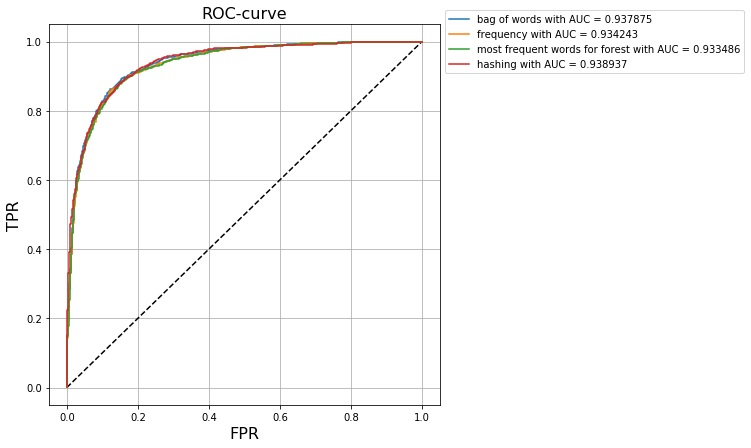

In [171]:
plt.figure(figsize = (7, 7))

plt.plot([0, 1], [0, 1], 'k--')

plt.plot(fpr, tpr, label= 'bag of words with AUC = {0:0.6f}'
               ''.format(metrics.auc(fpr, tpr)))
plt.plot(fpr_lr, tpr_lr, label= 'frequency with AUC = {0:0.6f}'
               ''.format(AUC_0))
plt.plot(fpr_lr_forest, tpr_lr_forest, label='most frequent words for forest with AUC = {0:0.6f}'
               ''.format(AUC_1))
plt.plot(fpr_hash, tpr_hash, label='hashing with AUC = {0:0.6f}'
               ''.format(AUC_2))
plt.xlabel('FPR', fontsize = 16)
plt.ylabel('TPR', fontsize = 16)
plt.title('ROC-curve', fontsize = 16)
plt.legend(bbox_to_anchor=(1, 1.05), loc = 2)
plt.grid()
plt.show()

Что вы можете сказать о качестве этих подходов к сокращению размерности?
Выведите топ-20 самых важных слов от случайного леса и сравните их с топ-20 наиболее частотных. Много ли общих слов?

При полном словаре (метода vectorizer) AUC-ROC было равно 0.937. Видно, что качество при сокращении размерности ухудшилось совсем немного. Хэширование показало даже более чуть высокий результат, чем был при большей размерности.
 
Выведем теперь топ-20 самых частотных слов.

In [143]:
vectorizer20 = CountVectorizer(max_features = 20, analyzer = "word", tokenizer = None, preprocessor = None, 
                             stop_words = None) 

train_data_features = vectorizer20.fit_transform(clean_train_reviews)
vectorizer20.vocabulary_

{'also': 0,
 'bad': 1,
 'even': 2,
 'film': 3,
 'first': 4,
 'get': 5,
 'good': 6,
 'like': 7,
 'made': 8,
 'make': 9,
 'movie': 10,
 'much': 11,
 'one': 12,
 'people': 13,
 'really': 14,
 'see': 15,
 'story': 16,
 'time': 17,
 'well': 18,
 'would': 19}

Выыедем топ-20 наиболее важных для случайного леса. Сначала поменяем местами keys и values в словаре vectorizer. В дальнейшем мы будем использовать этот новый словарь.

In [147]:
new_dict = {}
voc = vectorizer.vocabulary_

for key in vectorizer.vocabulary_.keys():
    value = voc[key]
    new_dict[value] = key

In [148]:
imp_indices = np.argsort(importances)[::-1]
imp_indices[:4]

array([ 3744, 23041, 60744, 59529])

In [151]:
for idx, imp in enumerate(imp_indices[:20]):
    print(idx, new_dict[imp])

0 bad
1 great
2 worst
3 waste
4 wonderful
5 excellent
6 best
7 awful
8 boring
9 terrible
10 movie
11 love
12 amazing
13 nothing
14 worse
15 well
16 even
17 plot
18 stupid
19 perfect


Таким образом, удалось сократить размерность более чем в три раза без сильной потери в качестве. Но даже 15000 признаков — это достаточно много. Допустим, мы хотим уменьшить размерность до 2000 признаков, однако можно заметить, что даже три предыдущие способа давали небольшое ухудшение в качестве. 

### PCA

Одним из способов сокращения размерности является метод главных компонент ([PCA](https://en.wikipedia.org/wiki/Principal_component_analysis)). Это преобразование позволяет получить вес каждого признака в компоненте. Например, если применить его к bag-of-words, можно найти наиболее важные слова, влияющие на данную компоненту. Для работы с большими разреженными матрицами в sklearn рекомендуется использовать [TruncatedSVD](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).

**(1 балл) Задание 9.**

Попробуйте сократить размерность до 2000 двумя способами:
 - наилучшим из трех предыдущих
 - для выборки со всеми признаками обучите *PCA*-преобразование 

Постройте новый график качества. Какой из двух подходов работает лучше?

Наилучшим из предыдущих оказалось хэширование. Начнём с него.

In [153]:
from sklearn.feature_extraction.text import HashingVectorizer

vectorizer_hash = HashingVectorizer(non_negative = True, n_features = 2000)

train_data_features = vectorizer_hash.fit_transform(clean_train_reviews)
train_data_features = train_data_features.toarray()

test_data_features = vectorizer_hash.transform(clean_test_reviews)
test_data_features = test_data_features.toarray()

lr = LogisticRegression(n_jobs = -1, random_state = 7)
lr.fit(train_data_features, y_train)

predpr_lr = lr.predict_proba(test_data_features)
fpr_hash, tpr_hash, thresholds = metrics.roc_curve(y_test, predpr_lr[:, 1])
AUC_2 = metrics.auc(fpr_hash, tpr_hash)
print('AUC-ROC:', AUC_2)

/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)


AUC-ROC: 0.9106088


Теперь применим PCA.

In [154]:
vectorizer = CountVectorizer(analyzer = "word", tokenizer = None, preprocessor = None, stop_words = None) 

train_data_features = vectorizer.fit_transform(clean_train_reviews)
train_data_features = train_data_features.toarray()

test_data_features = vectorizer.transform(clean_test_reviews)
test_data_features = test_data_features.toarray()

In [155]:
from sklearn.decomposition import TruncatedSVD

TrSVD = TruncatedSVD(n_components = 2000, random_state = 42)

TrSVD.fit(train_data_features)

train_df_svd = TrSVD.transform(train_data_features)
test_df_svd = TrSVD.transform(test_data_features)

In [156]:
print(train_df_svd.shape)
print(test_df_svd.shape)

(16000, 2000)
(4000, 2000)


In [157]:
lr = LogisticRegression(n_jobs = -1, random_state = 42)
lr.fit(train_df_svd, y_train)

predpr_lr = lr.predict_proba(test_df_svd)
fpr_svd, tpr_svd, thresholds = metrics.roc_curve(y_test, predpr_lr[:, 1])
AUC_3 = metrics.auc(fpr_svd, tpr_svd)
print('AUC-ROC:', AUC_3)

AUC-ROC: 0.934774133333


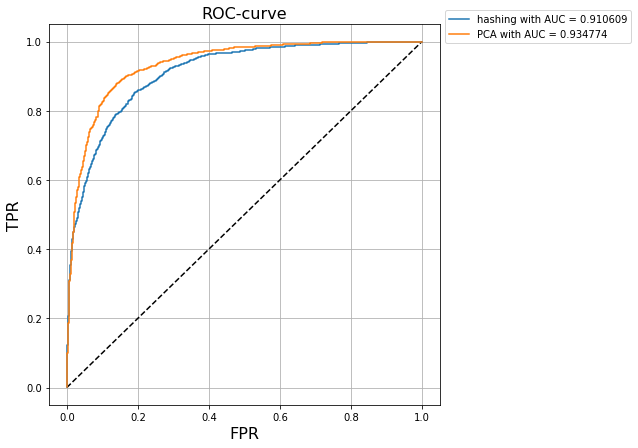

In [159]:
plt.figure(figsize = (7, 7))

plt.plot([0, 1], [0, 1], 'k--')

plt.plot(fpr_hash, tpr_hash, label='hashing with AUC = {0:0.6f}'
               ''.format(AUC_2))
plt.plot(fpr_svd, tpr_svd, label= 'PCA with AUC = {0:0.6f}'
               ''.format(AUC_3))
plt.xlabel('FPR', fontsize = 16)
plt.ylabel('TPR', fontsize = 16)
plt.title('ROC-curve', fontsize = 16)
plt.legend(bbox_to_anchor=(1, 1.05), loc = 2)
plt.grid()
plt.show()

Для первых трех компонент преобразования найдите топ-30 наиболее важных слов. Можете ли вы охарактеризовать как-то каждую из этих групп?

По графикам и площадям под графиками видно, что PCA работает лучше. Выведем топ-30 слов для первых трёх компонент.

In [179]:
components = TrSVD.components_[:3, :]
comp_sorted = []
for i in range(3):
    comp_sorted.append(np.argsort(components[i])[::-1])

In [180]:
table = pd.DataFrame(
    {'Component 1': [new_dict[comp_sorted[0][j]] for j in range(30)],
     'Component 2': [new_dict[comp_sorted[1][j]] for j in range(30)],
     'Component 3': [new_dict[comp_sorted[2][j]] for j in range(30)]})
table

,Component 1,Component 2,Component 3
0,movie,movie,one
1,film,movies,show
2,one,bad,like
3,like,good,even
4,good,like,time
5,even,watch,series
6,would,really,get
7,time,watching,would
8,really,acting,two
9,story,funny,well


К сожалению, я не увидела каких-то конкретных закономерностей.

### Какие еще могут быть способы обработки текстовых данных?

Как можно заметить, подход с мешком слов, в котором учитывается лишь факт вхождения слова в отзыв, весьма наивен, так как не позволяет учесть информацию в скольки отзывах встречалось данное слово (например, чтобы избавиться от очень редких слов). В этом случае может помочь [tf-idf кодирование](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html).

Другой недостаток описанного в задании подхода заключается в использовании абсолютных частот слов. У некоторых слов они могут быть очень большими, в то же время у других — низкими. Чтобы "сгладить" разницу между ними, можно сделать логарифмирование, т.е. применить преобразование $x \to log(x + 1)$ (так как при bag-of-words кодировании могут встречаться 0).

Неплохое руководство можно найти в разделе [извлечения признаков](http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction) из документации sklearn.


## Библиотека Vowpal Wabbit

Еще одним подходом для работы с текстовым данными является использование библиотеки [Vowpal Wabbit](https://github.com/JohnLangford/vowpal_wabbit/wiki).

VW представляет из себя хорошую реализация стохастического градиентного спуска для линейных моделей. К преимуществам и особенностям данной библиотеки можно отнести:
 - Считывание с диска происходит батчами, VW делает каждый следующий шаг градиентного спуска только по батчу, поэтому нет необходимости хранить всю выборку в памяти, из-за чего его удобно применять для больших выборок при ограниченных ресурсах.
 - Из коробки работают: нормализация признаков, взвешивание объектов, адаптивный градиентный шаг, матричные разложения, тематическое моделирование, активное обучение, обучение с подкреплением.
 - Реализация VW содержит различные методы оптимизации: сопряженные градиенты, квазиньютоновские методы (L-BFGS).
 - VW может быть запущен на кластере.

Перед началом работы с vw полезно будет ознакомиться с информацией по ссылкам:
 - [Ноутбук с семинара про VW (ближе к концу)](https://nbviewer.jupyter.org/urls/dl.dropbox.com/s/xswzs2g414wggh9/seminar_8.ipynb)
 - [Туториал по VW](https://github.com/JohnLangford/vowpal_wabbit/wiki/Tutorial)
 - [Описание формата входных данных](https://github.com/JohnLangford/vowpal_wabbit/wiki/Input-format)
 - [Описание параметров командной строки](https://github.com/JohnLangford/vowpal_wabbit/wiki/Command-line-arguments)

Приведите обучающую и тестовую выборки к формату пригодному для обучения модели с помощью vw: в качестве признаков используйте тексты отзывов как есть. Например:

In [13]:
import pandas as pd

df = pd.read_csv("feedback_data.tsv", sep="\t")
X = df["review"].as_matrix()
y = df["sentiment"].as_matrix()

In [16]:
from sklearn import cross_validation

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, 
                                                                     test_size = 0.2, 
                                                                     random_state = 42, 
                                                                     stratify = y)

In [17]:
import io
import re

def ReadFile(filename, X, y):
    lines = []
    for text, label in zip(X, y):
        new_line = '{} | {}'.format(1 if label == 1 else -1, ' '.join(re.findall(r'\w+', text)))
        lines.append(new_line)
    
    f = io.open(filename, 'w', encoding='utf8')
    f.write("\n".join(lines))
    f.close()

In [18]:
ReadFile("x_train.txt", X_train, y_train)
ReadFile("x_test.txt", X_test, y_test)

In [19]:
!head -1 x_train.txt

1 | I really dislike both Shrek films Since their both PG and have words in them I would never say myself so I disliked them br br But when it comes to Spirit Stallion of the Cimarron which I just barely watched for the first time last month I became a fan of animated films other than Pixar Spoilers ahead In Spirit Stallion of the Cimarron a horse foal is born and eventually becomes the leader of his heard One night he sees a strange light in the distance and he sets off toward it This action eventually leads to his capture and several more things Throughout the movie we hear a narration It s through the thoughts of Spirit though the horses never talk This is what makes the movie so goo They the movie makers recored real horses to do the sounds the horses made none of those sounds were made by humans br br Spirit meets Rain a beautiful mare and Little Creek a native American who owns Rain Little Creek later frees Spirit and Rain they go running home br br I have never been a big fan of

**(2 балла) Задание 10.**

Обучите Vowpal Wabbit на полученной выборке. В качестве функции потерь (параметр [loss_function](https://github.com/JohnLangford/vowpal_wabbit/wiki/Loss-functions)) попробуйте использовать:
  - логистическую (logistic)
  - кусочно-линейную (hinge)

Постройте *Precision-Recall* и *ROC* кривые для каждой из получившихся моделей. Сравните время обучения и получившееся качество со временем обучения и качеством предыдущих моделей.

In [59]:
import subprocess

def FitAndPredict(lossf):
    if lossf == 'logistic':
        print('Fit time:\n')
        %time !vw -d x_train.txt -f model_logistic.vw --loss_function logistic -c -k --random_seed 42 --quiet
        !vw -d x_test.txt -t -i model_logistic.vw --loss_function logistic -p log_pred.txt --quiet
    
    if lossf == 'hinge':
        print('Fit time:\n')
        %time !vw -d x_train.txt -f model_logistic.vw --loss_function hinge -c -k --random_seed 42 --quiet
        !vw -d x_test.txt -t -i model_logistic.vw --loss_function hinge -p hinge_pred.txt --quiet

def ReadPredictions(filename):
    with open(filename) as f:
        predictions = np.array(list(map(float, f.readlines())))
    return predictions

In [60]:
FitAndPredict('logistic')

Fit time:

CPU times: user 10.5 ms, sys: 18.1 ms, total: 28.6 ms
Wall time: 482 ms


In [61]:
FitAndPredict('hinge')

Fit time:

CPU times: user 10 ms, sys: 17.3 ms, total: 27.3 ms
Wall time: 446 ms


In [38]:
import numpy as np
import pylab as plt
from sklearn import metrics

predictions_lr = ReadPredictions('log_pred.txt')
predictions_hinge = ReadPredictions('hinge_pred.txt')

precision_lr, recall_lr, _ = metrics.precision_recall_curve(y_test, predictions_lr)
fpr_lr, tpr_lr, _ = metrics.roc_curve(y_test, predictions_lr)

precision_hinge, recall_hinge, _ = metrics.precision_recall_curve(y_test, predictions_hinge)
fpr_hinge, tpr_hinge, _ = metrics.roc_curve(y_test, predictions_hinge)

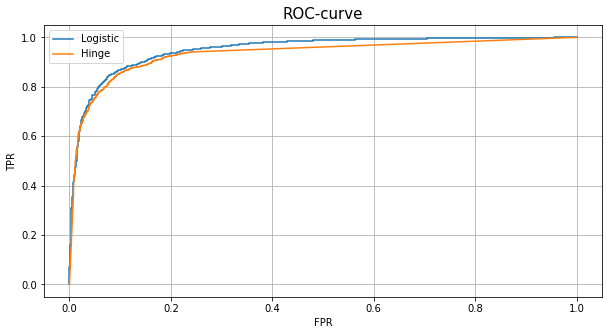

In [42]:
plt.figure(figsize=(10, 5))

plt.plot(fpr_lr, tpr_lr, label="Logistic")
plt.plot(fpr_hinge, tpr_hinge, label="Hinge")
plt.title('ROC-curve', fontsize=15)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid()
plt.legend()

plt.show()

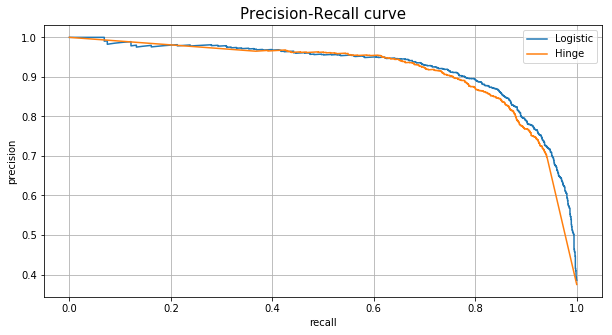

In [41]:
plt.figure(figsize=(10, 5))

plt.plot(recall_lr, precision_lr, label="Logistic")
plt.plot(recall_hinge, precision_hinge, label="Hinge")
plt.xlabel("recall")
plt.ylabel("precision")
plt.title("Precision-Recall curve", fontsize=15)
plt.grid()
plt.legend()

plt.show()

Получившееся качество:

In [43]:
print("Logistic AUC:", metrics.auc(fpr_lr, tpr_lr))
print("Hinge AUC:", metrics.auc(fpr_hinge, tpr_hinge))

Logistic AUC: 0.9506984
Hinge AUC: 0.9332704


Время обучения Vopal Wobbit существенно меньше, чем для предыдущих моделей (оно порядка миллисекунд, в то время как все предыдущие модели обучались не менее 30 секунд, а часто ещё дольше). А качество (показатель AUC) для логистической функции потерь достигло 0.95, что больше, чем для всех предыдущих методов.

## Выводы

**(0.5 балла) Задание 11.**

В первой части лабораторной работы мы рассмотрели 2 способа подбора гиперпараметров и калибровки алгоритмов машинного обучения. Ответьте на следующие вопросы:

- В каких случаях случайный поиск гиперпараметра имеет преимущество, в сравнении с перебором по сетке? Приведите пример такого случая.
- Для какого типа задач машинного обучения имеет смысл использовать калибровку предсказаний? Приведите пример такой задачи.

Приведенные примеры не должны совпадать с упомянутыми ранее в работе.

- Случайный поиск имеет преимущество над перебором по сетке в случае, когда перебираемых очень много. К тому же, случайному поиску обычно задается мелкая сетка, откуда он генерирует наборы гиперпараметров, а обычному GridSearch'у задают довольно грубую сетку. В результате оптимум на сетке для GridSearch может не быть достигнут из-за слишком грубой сетки. Например, имелась сетка 0, 20, 40, ..., 100, а оптимум достигался на 10. GridSearch его не найдёт. Если сделать менее грубую сетку 1, 2, 3, ..., 100 и воспользоваться RandomizedSearch, то появится вероятность достигнуть оптимума.



- Калибровка вероятностей важна для задач, где требуется не только предсказать правильный класс, но и вероятность принадлежности этому классу. Например, задача кредитного скоринга: иногда вместо ответа "Выдать кредит"/"Не выдать кредит" хочется иметь вероятность выплаты кредита данным клиентом.

**(0.5 балла) Задание 12.**

В второй части лабораторной работы мы рассмотрели несколько методов работы с текстовыми данными. Ответьте на следующие вопросы:

- Какие есть достоинства у рассмотренных методов представления текстовых данных? Поясните свой ответ для каждого рассмотренного метода.

Были рассмотрены два метода извлечения признаков из текста:

- bag-of-words: простой для понимания способ предстваления текста в виде матрицы. Достоинства: простота, лёгкая интерпретируемость, возможность получения слов текста по построенной матрице. Недостаток -- большой объём представления (хотя методы сжатия для разреженных матриц позволяют немного нивелировать этот недостаток).


- hashing trick: похож на bag of words, но есть хэширование слов. Из-за хеширования появляется возможность задать размерность. Однако его минус в том, что из-за коллизий бывает искажение информации, а также уменьшается интерпретируемость предсталения (по сравнению с bag-of-words).

Методы понижения размерности:

- hashing trick: снова он, так как, как уже было сказано выше, мы сами задаём размерность представления. По ROC-AUC критерию проиграл только PCA и Vopal Wobbit. Его большим плюсом является хорошая скорость работы.


- RandomForest, выбор признаков по значимости: плюсами данного подхода являются неплохая интерпретируемость и довольно хорошее качество (по сравнению с bag-of-words с исходной размерностью). Минусами являются низкая скорость работы и необходимость обучать RandomForest, что достаточно долго.


- PCA: очень долго работает, зато сильно сжимает данные (напрмер, в этой работе: с 65 тыс до двух) и при этом выдаёт очень высокое качество.


- Наиболее частотные слова. Плюсы: хорошая интерпретируемость. Минусы: возможно зашумление малоинформативными словами (например, stop-words).

- Каким общим недостатком обладают данные методы?

Нет учета порядка слов, никак не учитывается контекст слов. Ещё слова-синонимы считаются совершенно отдельными, в то время как их можно было бы объединять в единую смысловую группу.

- Какие модели машинного обучения больше подходят для работы с текстовыми данными на практике и почему? В чём их преимущество перед другими алгоритмами?

Важным критерием выбора модели для работы с текстом является время её обучения. В связи с этим наиболее часто используются линейные модели (SVM, логистическая регрессия).  В частности, Vopal Wobbit должен хорошо помогать в работе с текстами.